 ╔══<i><b>Alai-DeepLearning</b></i>═══════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;week 2. Numpy Basis**
# Section 7. Numpy을 활용하여 머신러닝 구현하기 - K-Means 군집화

### _Objective_
1. 대표적인 군집화 방법론 중 하나인 K-Means에 대해서 배워보고, 이를 Numpy로 구현해 봅니다.<br>

╚════════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

# \[ 1. K-Means 알고리즘 개괄 \]

---

---

> _K-Means 알고리즘은 주어진 데이터를 K개의 클러스터로 묶는 알고리즘으로, 각 클러스터와 거리 차이의 분산을 최소화하는 방식으로 동작합니다._

In [2]:
# 예제 데이터셋 준비하기
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
dataset = np.loadtxt("./kmeans_dataset.txt")

--2019-03-19 10:44:24--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.60.77
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.60.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520 (1.5K) [text/plain]
Saving to: ‘kmeans_dataset.txt.1’

kmeans_dataset.txt. 100%[===================>]   1.48K  --.-KB/s    in 0s      

2019-03-19 10:44:25 (32.9 MB/s) - ‘kmeans_dataset.txt.1’ saved [1520/1520]



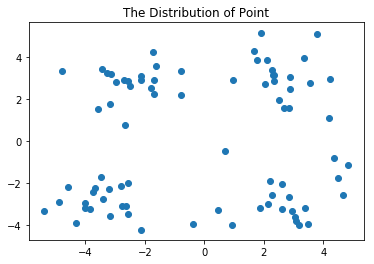

In [3]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1])
plt.show()

우리는 직관적으로 보았을 떄, 크게 4개의 군집이 있음을 파악할 수 있습니다. 

예로 들어 아래와 같은 중심을 기준으로 나누어 볼 수 있습니다.

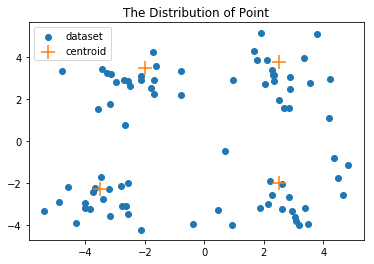

In [4]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1],label='dataset')
plt.scatter([-3.5,-2,2.5,2.5],[-2.3,3.5,3.8,-2],
            s=200, label="centroid", marker='+')
plt.legend()
plt.show()

> 우리는 위와 같이, 4개의 군집으로 묶어 주기 위해서, 기준이 필요하다. KNN에서와 마찬가지로, **중심점과 점 간의 거리**를 구해, 그 거리가 가장 작은 중심점을 찾도록, 중심 점을 반복적으로 옮겨가는 과정을 K-Means 군집화라고 합니다.

# \[ 2. K-Means Numpy로 구현 \]

---

---

K-means의 알고리즘 순서 

1. 초기 중심점을 설정하기 위해 K개의 점 생성(일반적으로 임의)
2. 중심점과 각 데이터 사이의 거리를 계산
3. 각 데이터를 거리가 가장 가까운 군집으로 할당
4. 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
5. 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄

> K-Means의 각 단계별로 코드를 작성해 보자. 

## 1. 각 단계별로 Numpy Code 작성하기


### (1) 초기 중심점을 설정하기 위해 K개의 점 생성

우리는 데이터셋 내의 공간에서 임의의 점 K(여기선 4개)를 랜덤하게 산출합니다. 

중심점이 데이터 셋 부근에 있기 위해서는 데이터셋의 범위 내에서 산출해야 합니다.

In [5]:
k = 4 # K점의 수

min_x = dataset[:,0].min()
max_x = dataset[:,0].max() 
np.random.uniform(low=min_x,
                  high=max_x)

1.258530960903589

위와 같은 방법으로 범위 내 랜덤한 값을 산출할 수 있습니다.

In [6]:
min_x = dataset[:,0].min()
max_x = dataset[:,0].max() 
min_y = dataset[:,1].min()
max_y = dataset[:,1].max() 

centroids = []
for _ in range(k):
    center_x = np.random.uniform(low=min_x, high=max_x)
    center_y = np.random.uniform(low=min_y, high=max_y)
    centroids.append([center_x,center_y])
centroids = np.array(centroids)

위의 코드를 좀 더 numpy답게 작성하면 아래처럼 작성할 수 있습니다.

In [7]:
center_x = np.random.uniform(low=min_x, high=max_x, size=k)
center_y = np.random.uniform(low=min_y, high=max_y, size=k)
centroids = np.stack([center_x,center_y],axis=-1)

위와 같이 랜덤으로 산출한 중심점은 아래와 같이 산재해 있습니다.

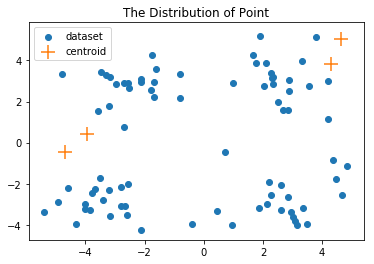

In [8]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1],label='dataset')
plt.scatter(centroids[:,0],centroids[:,1],
            s=200, label="centroid", marker='+')
plt.legend()
plt.show()

### (2) 중심점과 각 데이터 사이의 거리를 계산

거리 공식은 KNN 때와 마찬가지로, 아래와 같습니다. 우리는 모든 중심점과 각 데이터 간 거리를 구해야 합니다.

$$
point1 = (x_1,y_1), point2 = (x_2,y_2)\mbox{일 때}\\
distance\_between\_point1\_and\_point2 = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}
$$

In [9]:
dists = []
for center in centroids:
    # 각 중심점을 기준으로, 각 데이터 간 거리 계산
    dist_from_center = []
    for point in dataset:
        # 거리 계산
        dist = np.sqrt(((center - point)**2).sum())
        dist_from_center.append(dist)
    dists.append(dist_from_center)
# 중심점 별 거리 계산
dists = np.array(dists)
dists

array([[ 3.08591539,  8.26463026,  6.18805211, 13.08204501,  4.24195662,
         8.93553822,  9.33519433, 10.57968028,  3.97015119,  8.02364712,
         9.15517631, 11.02244079,  2.09647948,  7.09116671,  6.78132714,
        10.31537093,  3.9097172 ,  5.69938664,  8.56312723, 10.73074049,
         3.16620067,  6.89996124,  7.36374278, 11.22177804,  3.09717781,
         6.93315232,  7.38131167, 11.95433263,  2.90617541,  8.47378752,
         9.78890114, 11.07049119,  3.47513437,  8.49029136,  5.86267661,
        11.18417034,  2.76812698,  6.15064848,  7.90379234, 11.86481298,
         2.80188025,  7.65812899,  8.31848081, 11.47843747,  2.97226577,
         8.13046007,  8.98564971, 11.24940857,  2.51359698,  6.43852954,
         8.4058225 , 12.69143069,  0.86663054,  9.58669368,  8.53892783,
        11.7991686 ,  3.75329087,  7.554912  ,  8.67062328, 11.63099254,
         3.09311492,  7.52857874,  9.05603471, 10.08712293,  1.6869019 ,
         6.43740567,  7.95507789, 10.93423086,  2.9

In [10]:
dists.shape # dists 행렬의 형태

(4, 80)

In [11]:
dists[1,32] # 1번째 중심점과 32번째 데이터 간 거리

2.505056040735233

* Numpy Code의 reshape와 broadcasting을 활용하면 간결하게 나타낼 수 있습니다.

In [12]:
diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
dists = np.sqrt((diff_mat**2).sum(axis=-1))
dists.shape

(4, 80)

### (3) 각 데이터를 거리가 가장 가까운 군집으로 할당

각 데이터를 거리가 가장 가까운 군집으로 할당 하기 위해서는, `argmin`을 통해 간단히 구할 수 있습니다.

In [13]:
cluster_per_point = dists.argmin(axis=0)
cluster_per_point

array([1, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 2, 1, 3,
       1, 2, 1, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 2, 0, 3, 1, 2, 1, 3, 1, 2,
       1, 3, 1, 2, 1, 3, 3, 2, 0, 3, 1, 2, 1, 3, 3, 2, 1, 3, 1, 2, 1, 3,
       1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2])

각 점에서 가장 가까운 중심점의 index를 위와 같은 방식으로 산출할 수 있습니다.

### (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산

In [14]:
# 각 군집별로 순회
for i in range(k):
    # 각 군집에 해당하는 점들의 집합
    target_point = dataset[cluster_per_point==i]
    
    # 각 군집의 평균을 군집의 중심점으로 할당
    centroids[i] = target_point.mean(axis=0) 

### (5) 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄

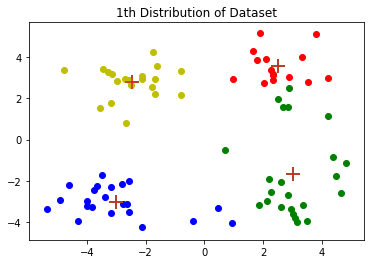

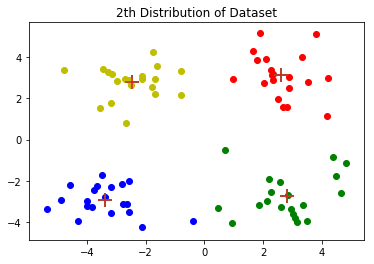

In [15]:
num_data = dataset.shape[0]

cluster_per_point = np.ones((num_data))

counter = 0
while True:
    prev_cluster_per_point = cluster_per_point
    
    diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
    dists = np.sqrt((diff_mat**2).sum(axis=-1))
    cluster_per_point = dists.argmin(axis=0)

    for i in range(k):
        centroids[i] = dataset[cluster_per_point==i].mean(axis=0)
        
    if np.all(prev_cluster_per_point == cluster_per_point):
        break
        
    counter += 1
    plt.title("{}th Distribution of Dataset".format(counter))
    for idx, color in enumerate(['r','g','b','y']):
        mask = (cluster_per_point==idx)
        plt.scatter(dataset[mask,0],dataset[mask,1],
                    label='dataset', c=color)
        plt.scatter(centroids[:,0],centroids[:,1],
                    s=200, label="centroid", marker='+')
    plt.show()

## 2. 전체 Numpy Code 작성하기

In [16]:
def cluster_kmeans(dataset, k):    
    # (1) 중심점 초기화
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    
    # (2) ~ (5) 순회
    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point
        
        # (2) 거리 계산
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = np.sqrt((diff_mat**2).sum(axis=-1))
        # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
        cluster_per_point = dists.argmin(axis=0)
        
        # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
    
    return centroids

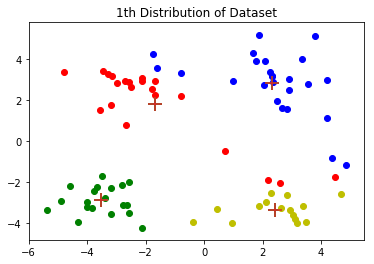

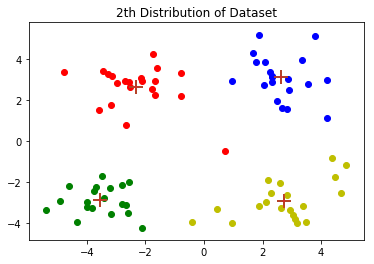

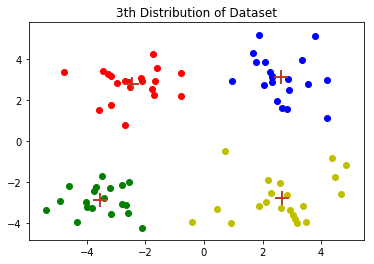

array([[-2.46154315,  2.78737555],
       [-3.53973889, -2.89384326],
       [ 2.6265299 ,  3.10868015],
       [ 2.65077367, -2.79019029]])

In [17]:
cluster_kmeans(dataset,4)

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/04

---